In [1]:
# add reload command of libraries
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn

import pickle

import matplotlib.pyplot as plt
from multi_rnn.model import MiltiRegionRNN
from multi_rnn.train import train
from multi_rnn.tasks import DataSet
from multi_rnn.eval import *

import pandas as pd
from multi_rnn.msa import MSA

/home/shrey/miniconda3/envs/multi-rnn/lib/python3.11/site-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn
/home/shrey/miniconda3/envs/multi-rnn/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
task_dict = {
    "PerceptualDecisionMaking-v0": {
        "dt": 100
    },

    "DelayMatchSample-v0": {
        "dt": 100,
    },

    "IntervalDiscrimination-v0": {
        "dt": 100
    },

    "ReadySetGo-v0": {
        "dt": 100
    }
}

seq_len = 100
bs = 128
device = "cuda:1"
hidden_size = 64

dataset = DataSet(seq_len, bs, device, task_dict)


In [4]:
with open("subgraph_data.pkl", "rb") as f:
    subgraph_data = pickle.load(f, encoding='latin1')
connectome = torch.tensor(subgraph_data['fln_mat']).to(device).float()

In [5]:
net = MiltiRegionRNN(input_size=4, hidden_size=hidden_size, output_size=3, connectome=connectome).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=3e-3, weight_decay=3e-5)

In [ ]:
train(net, dataset, optimizer, criterion, 5000, device, plot_loss=True)

In [6]:
#torch.save(net.state_dict(), f"model_{'_'.join(task_dict.keys())}.pt")
net.load_state_dict(torch.load(f"model_{'_'.join(task_dict.keys())}.pt"))

<All keys matched successfully>

In [7]:
get_task_wise_accuracy(dataset, 10, net)

{'PerceptualDecisionMaking-v0': 0.8888671875,
 'DelayMatchSample-v0': 1.0,
 'IntervalDiscrimination-v0': 1.0,
 'ReadySetGo-v0': 1.0}

(100, 512, 4)


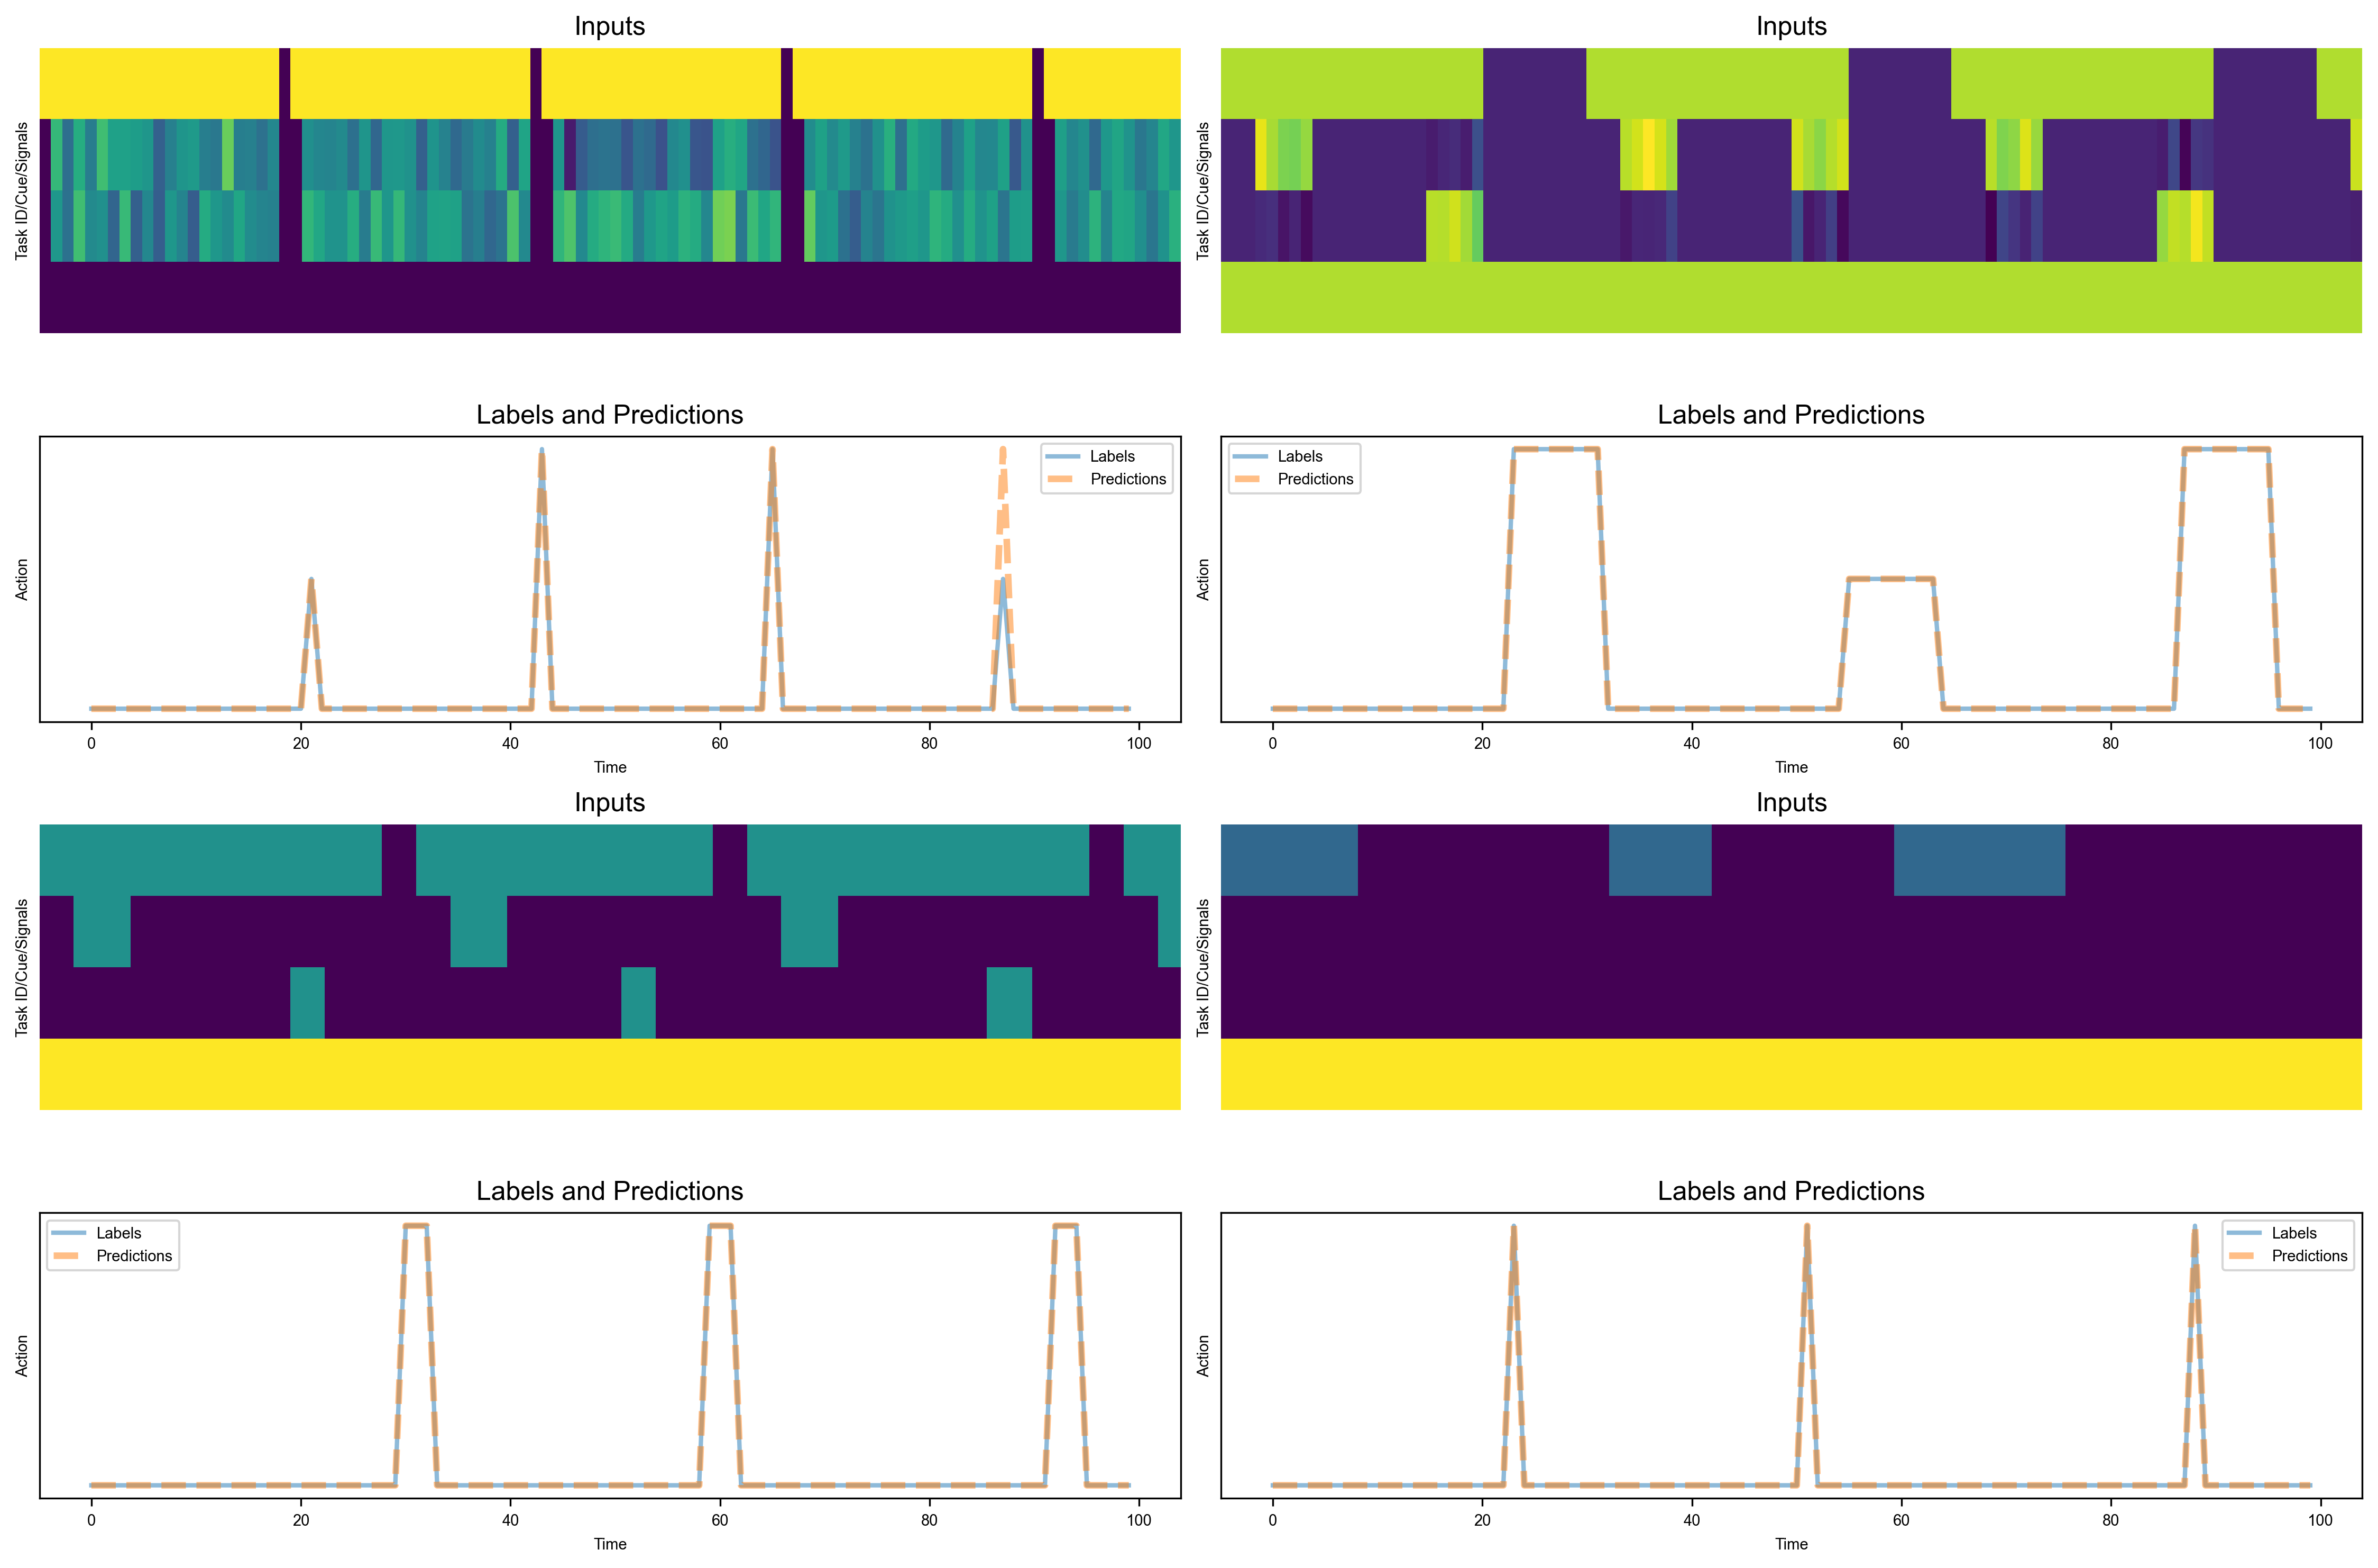

In [8]:
plot_example_from_each_task(dataset, bs, net, None, "Task ID/Cue/Signals")

In [9]:
msa = MSA(net, dataset, 10, 500, list(range(29)))

In [66]:
shapley_modes = msa.run_msa()
shapley_modes.columns = list(subgraph_data["areas"])
shapley_modes.index = list(task_dict.keys())
df_melted = pd.DataFrame(shapley_modes).melt(var_name='Column', value_name='Shapley Value', ignore_index=False).reset_index()
df_melted.rename(columns={'index': 'Task'}, inplace=True)

In [10]:
df_melted = pd.read_csv("shapley_modes.csv" , index_col=0)

/tmp/ipykernel_1295344/2283439603.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=12)


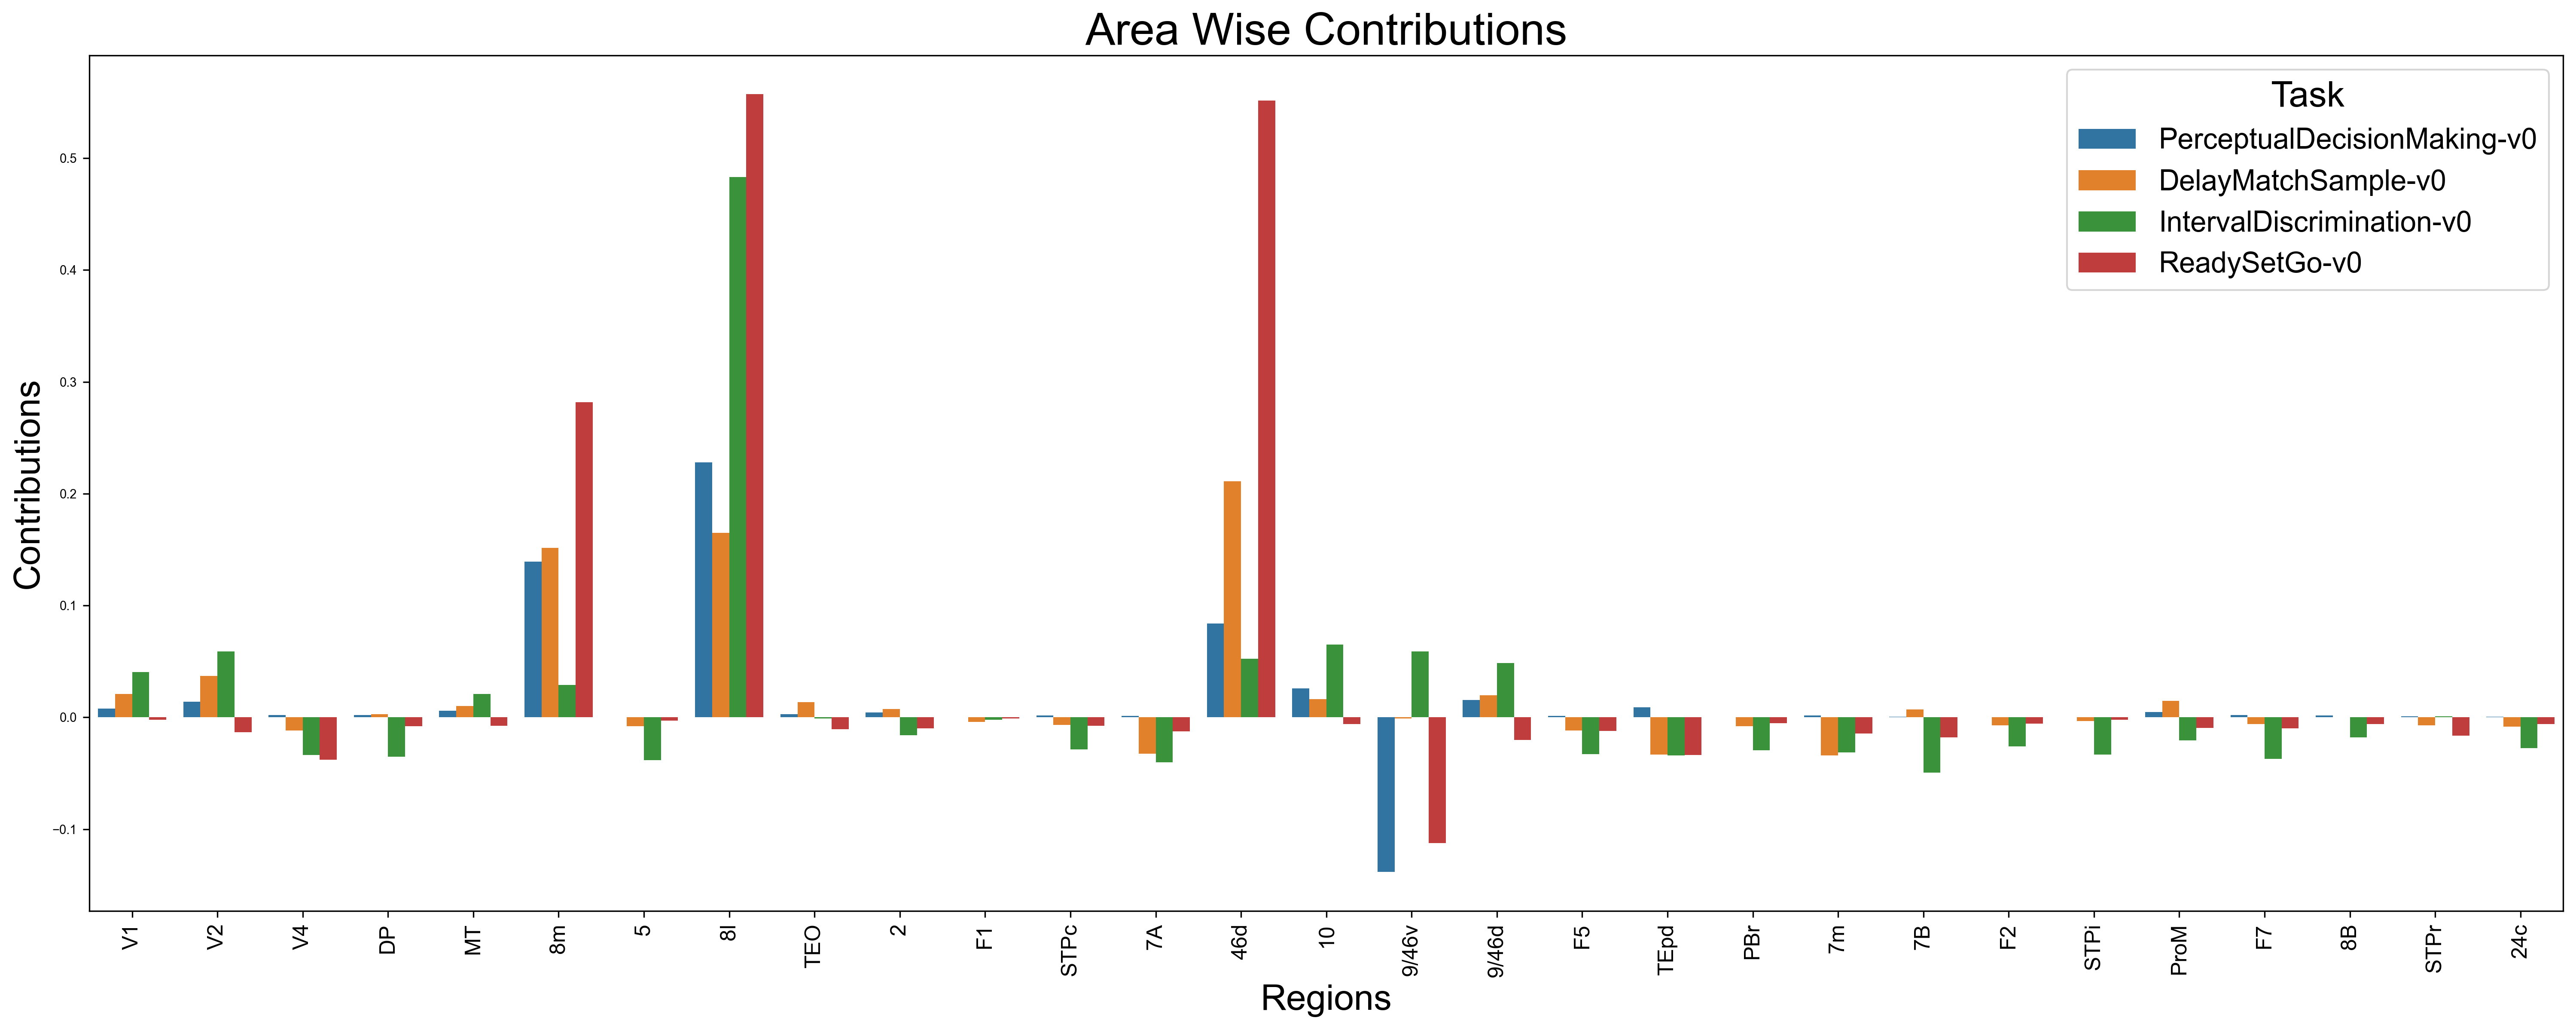

In [11]:
# Plotting the bar graph
plt.figure(figsize=(20, 8), dpi=300)
ax = sns.barplot(x='Column', y='Shapley Value', hue='Task', data=df_melted)

# Adding labels and title
ax.set_xlabel("Regions", fontsize=20)
ax.set_ylabel("Contributions", fontsize=20)
ax.set_title("Area Wise Contributions", fontsize=25)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=12)

# Displaying the plot
plt.tight_layout()
plt.legend(title='Task', fontsize=16, title_fontsize=20)
plt.show()

In [12]:
task_wise_contributions = df_melted.pivot(index='Task', columns='Column', values='Shapley Value').values
correlation = np.corrcoef(task_wise_contributions)

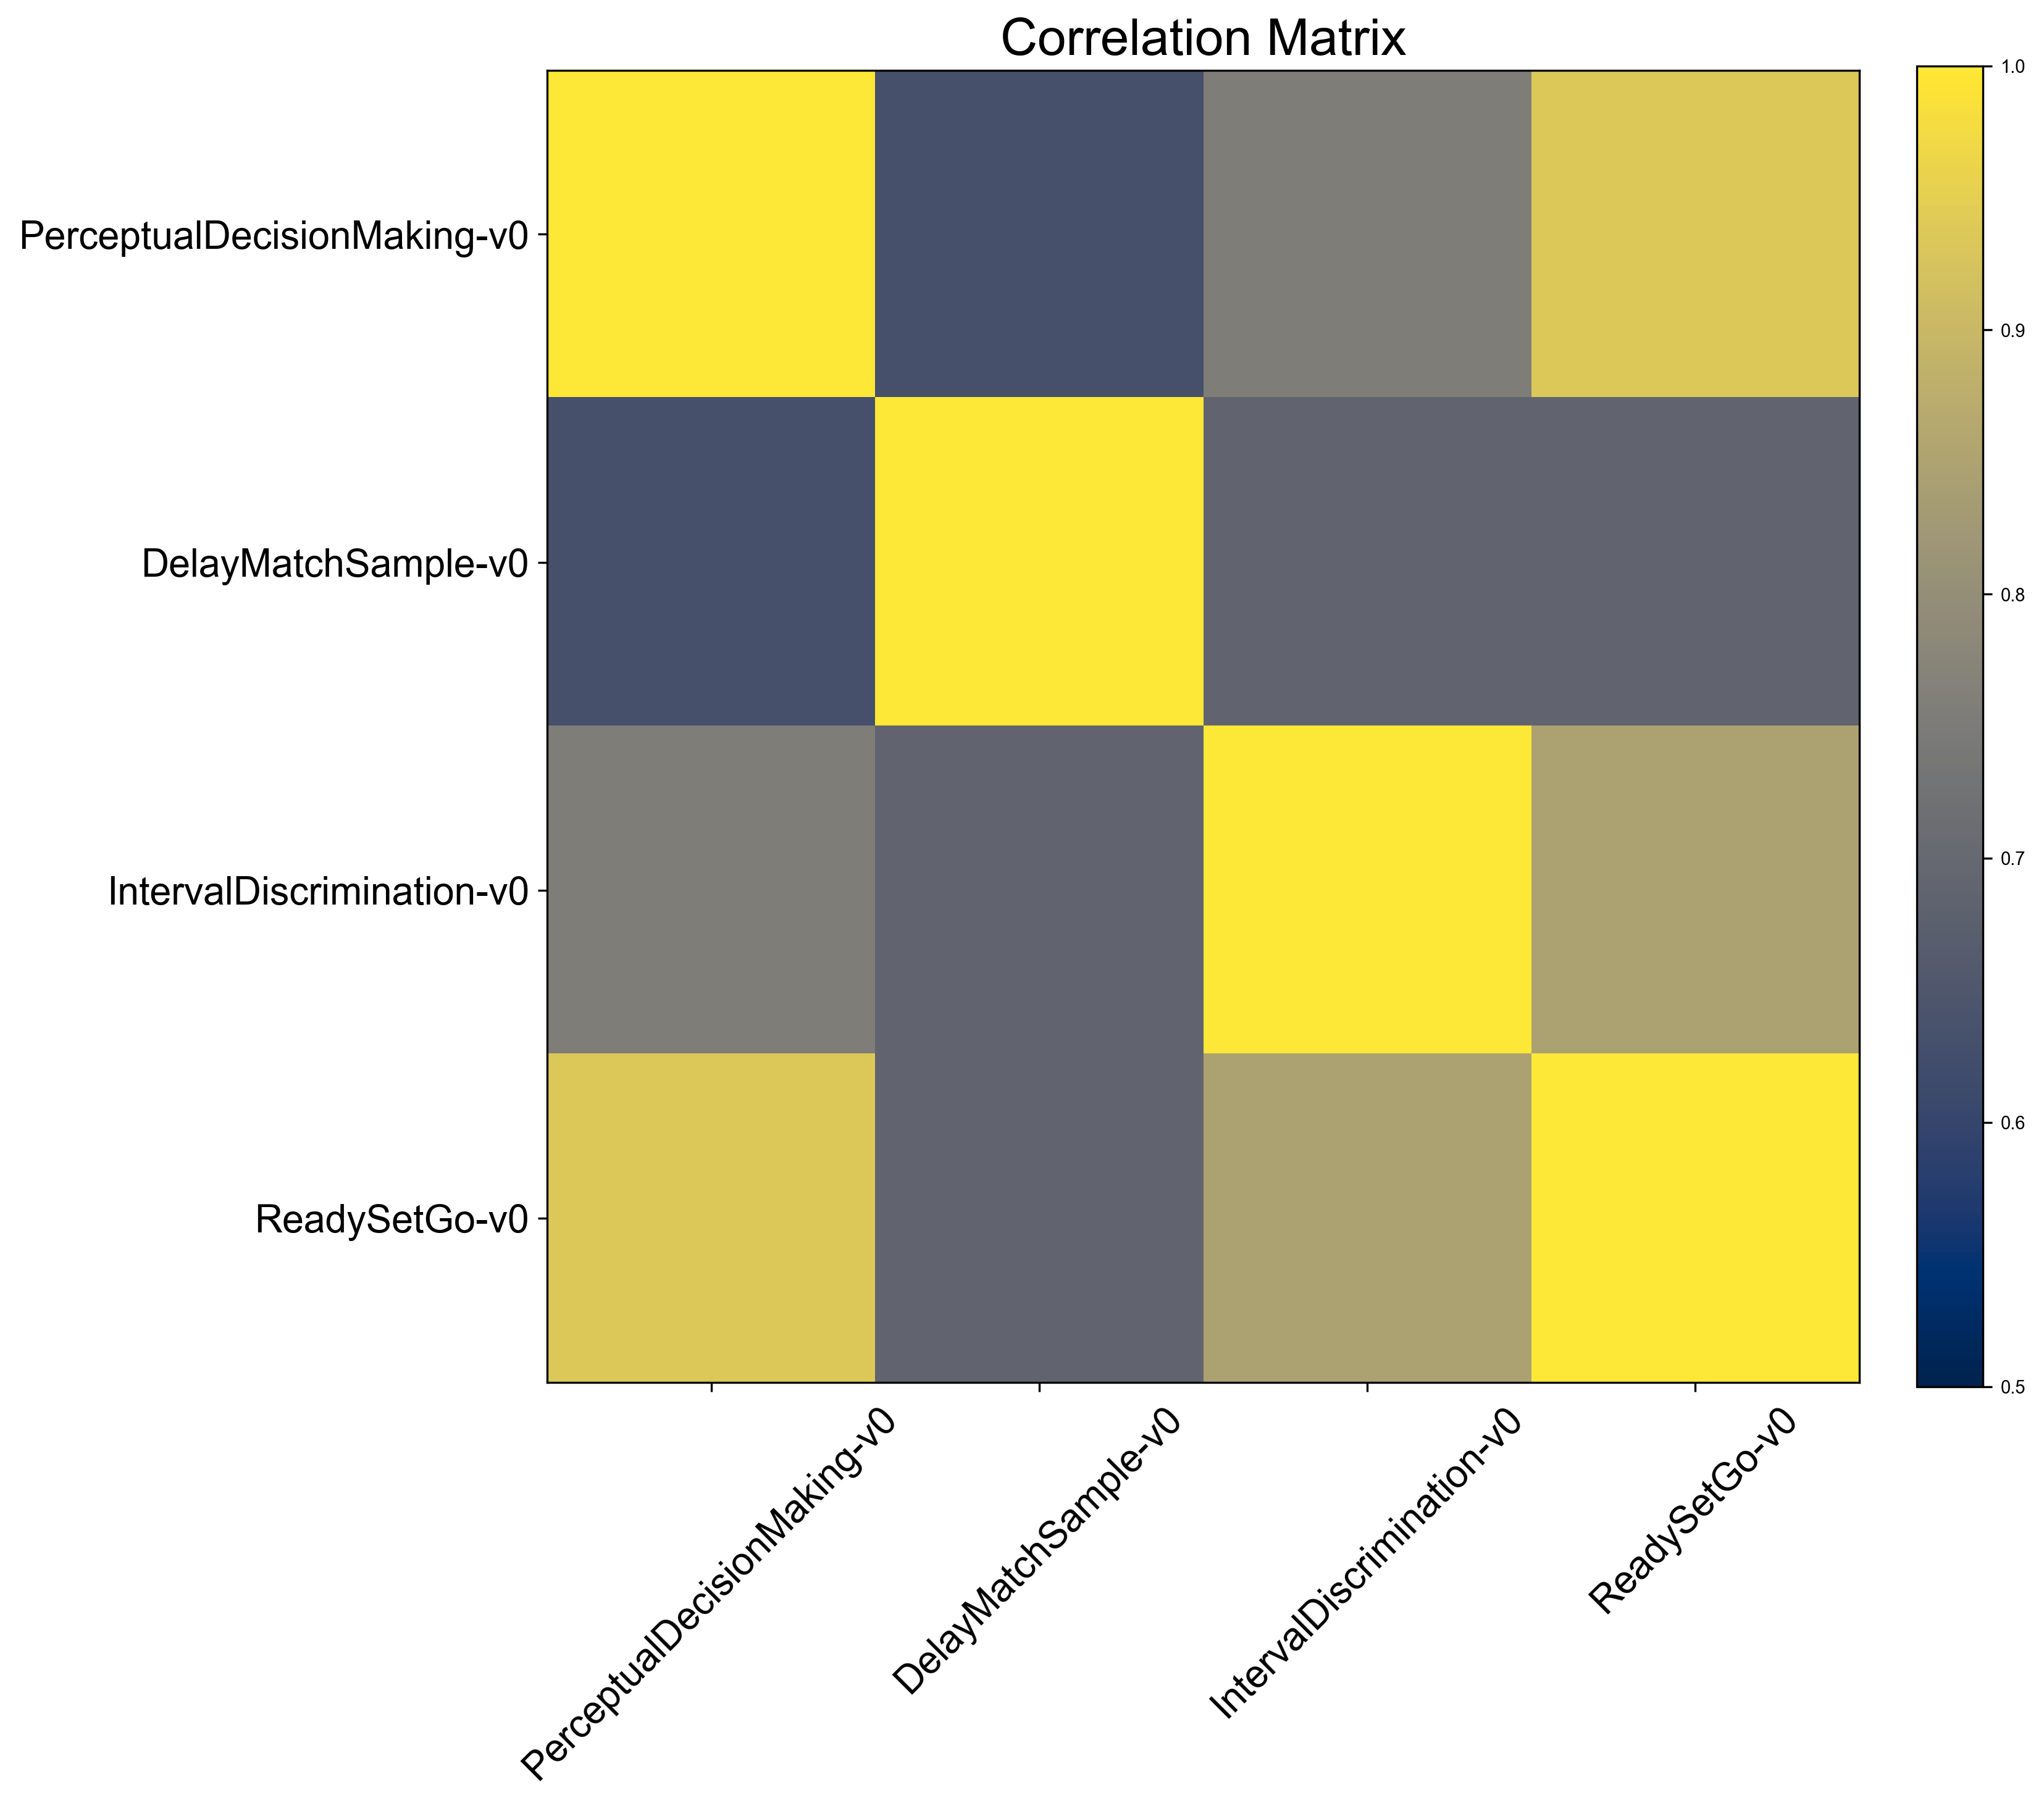

In [13]:
plt.figure(figsize=(10, 10), dpi=300)
plt.imshow(
    correlation,
    interpolation="nearest",
    vmax = 1,
    vmin = 0.5,
    cmap = "cividis"
)
plt.xticks(np.arange(len(task_dict.keys())), task_dict.keys(), rotation=45, fontsize=15)
plt.yticks(np.arange(len(task_dict.keys())), task_dict.keys(), fontsize=15)
plt.colorbar(fraction=0.046, pad=0.04)  # Display color bar
plt.title("Correlation Matrix", fontsize=20)
plt.show()

In [ ]:
network_interaction = msa.get_network_interactions()
network_interaction = pd.DataFrame(network_interaction, index=list(subgraph_data["areas"]), columns=list(subgraph_data["areas"]))

In [14]:
network_interaction = pd.read_csv("network_interaction.csv", index_col=0)

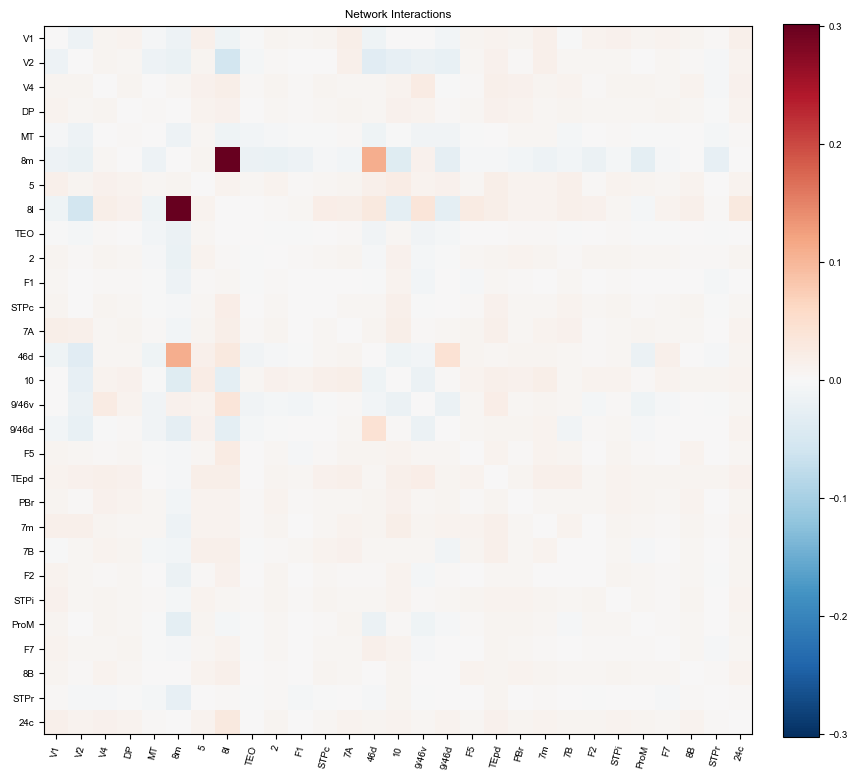

In [15]:
vmax = np.max(
    np.abs(network_interaction.values)
)  # Find the maximum absolute value in the data
vmin = -vmax  # Set vmin to the negative of vmax to center the colormap at 0

plt.figure(figsize=(10, 10))
plt.imshow(
    network_interaction.values,
    cmap="RdBu_r",
    interpolation="nearest",
    vmin=vmin,
    vmax=vmax,
)
plt.xticks(np.arange(len(network_interaction.columns)), network_interaction.columns, rotation=75)
plt.yticks(np.arange(len(network_interaction.columns)), network_interaction.columns)
plt.colorbar(fraction=0.046, pad=0.04)  # Display color bar
plt.title("Network Interactions")
plt.show()